* Data pipeline for the image ETL

In [18]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tf.enable_eager_execution()
tf.VERSION

'1.11.0'

In [2]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

AttributeError: 'module' object has no attribute 'experimental'

In [5]:
import pathlib
# data_root = tf.keras.utils.get_file('flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)
data_root = pathlib.Path('./data/train/')
print(data_root)

data/train


In [6]:
for item in data_root.iterdir():
  print(item)

data/train/snapper
data/train/bream


In [14]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count
all_image_paths[:10]

['data/train/bream/yellowfin-bream.jpg', 'data/train/snapper/red-snapper.jpg']

In [12]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['bream', 'snapper']

In [13]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'bream': 0, 'snapper': 1}

In [15]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [0, 1]


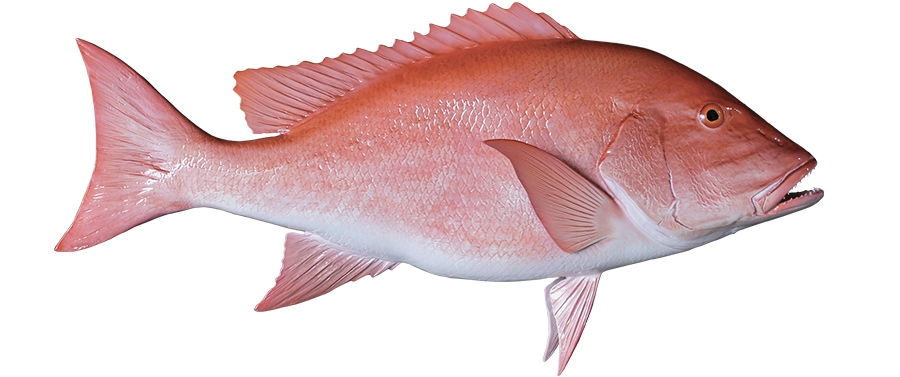

In [19]:
import IPython.display as display
for n in range(2):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
#   print(caption_image(image_path))
  print()

The preprocessing include a resize action. Currently we are using squash method - ignore the ration and turn it to square. Please check [this article](https://forums.fast.ai/t/impact-of-image-resizing-on-model-training-time-and-performance/1980) to see the comparison amoung the different methods of resizing

In [20]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize_images(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

In [21]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

In [33]:
import matplotlib.pyplot as plt

image_path = all_image_paths[1]
label = all_image_labels[1]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
# # plt.xlabel(caption_image(image_path))
plt.title(label_names[label].title())
plt.show()